In [1]:
#spark log level to show errors
sc.setLogLevel("ERROR")
#setting up path + reading my csv from bucket
bucket='my-project-bucket-nrpc'
filename='models/model_itineraries.parquet'
file_path = 'gs://'+ bucket+'/'+filename

sdf= spark.read.parquet(file_path)

sdf.printSchema()

root
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: double (nullable = true)
 |-- totalTravelDistance: double (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDepartureAirportCode: string (nullable = true)
 |-- segmentsAirlineCode: string (nullable = true)
 |-- segmentsCabinCode: string (nullable = true)
 |-- leadTime: integer (nullable = true)
 |-- scaledvector: vector (nullable = true)
 |-- scalednums: vector (nullable = true)
 |-- isRefundable_binary: integer (nullable = true)
 |-- isNonStop_binary: integer (nullable = true)
 |-- isBasicEconomy_binary: integer (nullable = true)


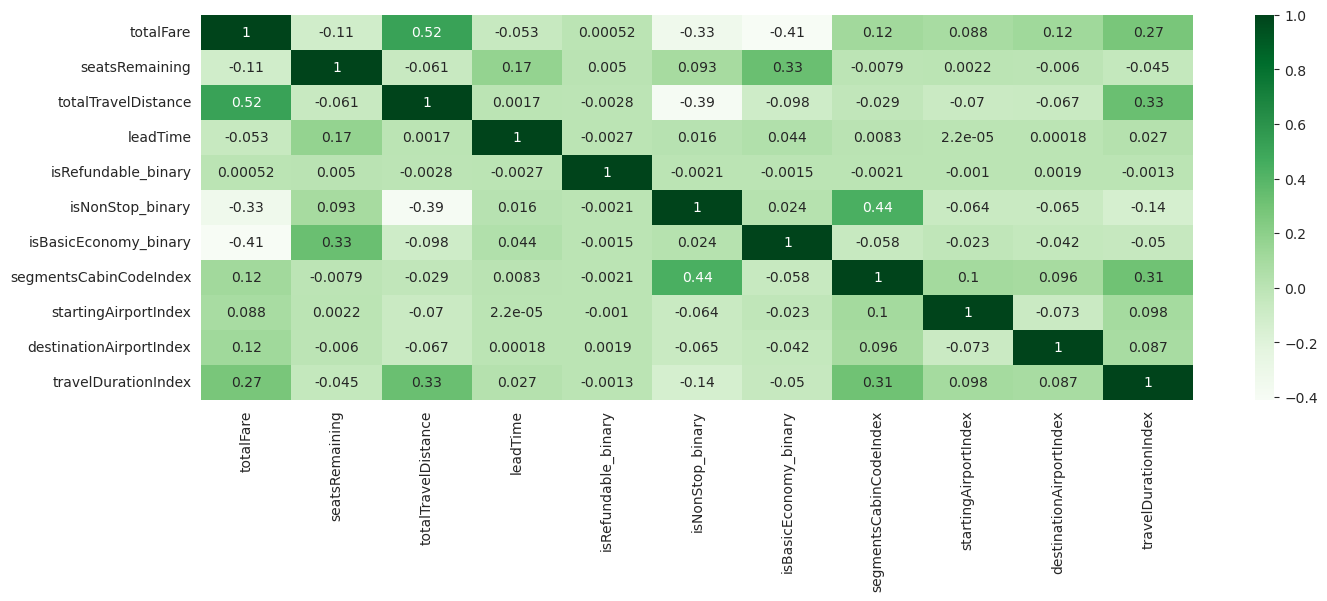

In [16]:
# Correlation matrix using Seaborn
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import pandas as pd

# Convert the numeric values to vector columns
vector_column = "correlation_features"
# Choose the numeric (Double) columns 
#I added my integers as well
numeric_columns = ['totalFare', 'seatsRemaining', 'totalTravelDistance', 'leadTime',
    'isRefundable_binary', 'isNonStop_binary', 'isBasicEconomy_binary',
    'segmentsCabinCodeIndex', 'startingAirportIndex', 'destinationAirportIndex', 'travelDurationIndex']

assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_column)
sdf_vector = assembler.transform(sdf).select(vector_column)

# Create the correlation matrix, then get just the values and convert to a list
matrix = Correlation.corr(sdf_vector, vector_column).collect()[0][0]
correlation_matrix = matrix.toArray().tolist() 
# Convert the correlation to a Pandas dataframe
correlation_matrix_df = pd.DataFrame(data=correlation_matrix, columns=numeric_columns, index=numeric_columns) 

heatmap_plot = plt.figure(figsize=(16,5))  
# Set the style for Seaborn plots
sns.set_style("white")

sns.heatmap(correlation_matrix_df, 
            xticklabels=correlation_matrix_df.columns.values,
            yticklabels=correlation_matrix_df.columns.values,  cmap="Greens", annot=True)
plt.savefig("correlation_matrix.png")

In [4]:
# Saving Seaborn Heatmap plot to GCS
import io
from google.cloud import storage
# Create a buffer to hold the figure
img_data = io.BytesIO()
# Write the figure to the buffer
heatmap_plot.savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to Google Cloud Storage
storage_client = storage.Client()
# Point to the bucket
bucket = storage_client.get_bucket('my-project-bucket-nrpc')

# Create a blob to hold the data. Give it a file name
blob = bucket.blob("correlation_matrix_plot.png")
# Upload the img_data contents to the blob
blob.upload_from_file(img_data)


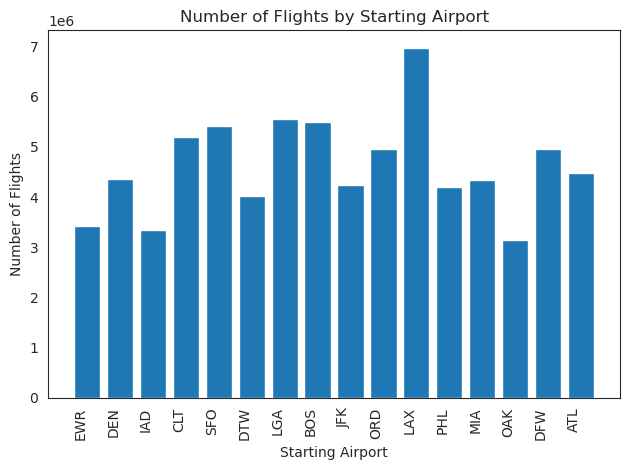

In [5]:
## Number of Flights in starting airport
import matplotlib.pyplot as plt
# Use groupby to get a count by date. Then convert to pandas dataframe
df = sdf.groupby("startingAirport").count().toPandas()

# Matplotlib create a figure
startingAirport_fig = plt.figure(facecolor='white')
plt.bar(df['startingAirport'], df['count'])
# Set the x-axis label
plt.xlabel("Starting Airport")
# Set the y-axis label
plt.ylabel("Number of Flights")
# Set the Title of the plot
plt.title("Number of Flights by Starting Airport")
plt.xticks(rotation=90, ha='right')
startingAirport_fig.tight_layout()
# Save the figure
plt.savefig("starting_airport_count_matplotlib.png")
# If running in Jupyter Notebook call plt.show()
plt.show()


In [6]:
df.head(16)

,startingAirport,count
0,EWR,3414039
1,DEN,4360528
2,IAD,3351356
3,CLT,5194029
4,SFO,5420414
5,DTW,4013325
6,LGA,5562042
7,BOS,5496094
8,JFK,4231867
9,ORD,4961028


In [7]:
# Save the plot to GCS
import io
from google.cloud import storage

# Create a buffer to hold the figure
img_data = io.BytesIO()
# Write the Matplotlib figure to the buffer
startingAirport_fig.savefig(img_data, format='png', bbox_inches='tight')

# Rewind the pointer to the start of the data
img_data.seek(0)
# Connect to Google Cloud Storage
storage_client = storage.Client()
# Point to the bucket
bucket = storage_client.get_bucket(bucket)

# Create a blob to hold the data. Give it a file name
blob = bucket.blob("startingAirport_count_matplotlib.png")
# Upload the img_data contents to the blob
blob.upload_from_file(img_data)

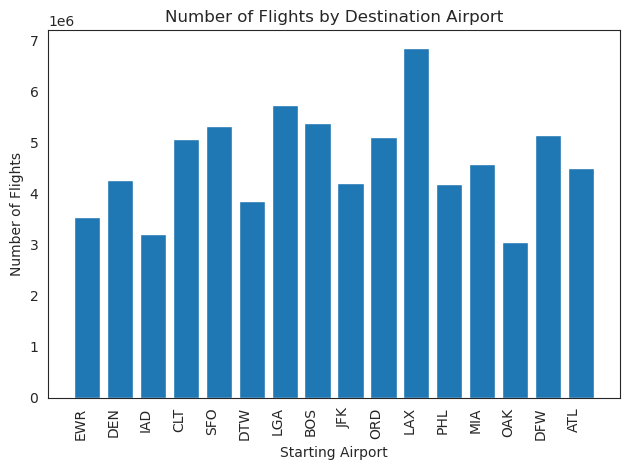

In [8]:
## Number of Flights in destination airport
import matplotlib.pyplot as plt
# Use groupby to get a count by date. Then convert to pandas dataframe
df = sdf.groupby("destinationAirport").count().toPandas()
# Matplotlib create a figure
destination_airport_fig = plt.figure(facecolor='white')
plt.bar(df['destinationAirport'], df['count'])
# Set the x-axis label
plt.xlabel("Starting Airport")
# Set the y-axis label
plt.ylabel("Number of Flights")
# Set the Title of the plot
plt.title("Number of Flights by Destination Airport")
plt.xticks(rotation=90, ha='right')
destination_airport_fig.tight_layout()
# Save the figure
plt.savefig("destinationAirport_count_matplotlib.png")
# If running in Jupyter Notebook call plt.show()
plt.show()


In [9]:
df.head(16)#get info on count from bar graph

,destinationAirport,count
0,EWR,3544107
1,DEN,4274262
2,IAD,3204302
3,CLT,5077050
4,SFO,5319574
5,DTW,3856385
6,LGA,5749759
7,BOS,5394216
8,JFK,4217350
9,ORD,5118241


In [10]:
# Save the plot to GCS
import io
from google.cloud import storage

# Create a buffer to hold the figure
img_data = io.BytesIO()
# Write the Matplotlib figure to the buffer
destination_airport_fig.savefig(img_data, format='png', bbox_inches='tight')

# Rewind the pointer to the start of the data
img_data.seek(0)
# Connect to Google Cloud Storage
storage_client = storage.Client()
# Point to the bucket
bucket = storage_client.get_bucket('my-project-bucket-nrpc')

# Create a blob to hold the data. Give it a file name
blob = bucket.blob("destinationAirport_count_matplotlib.png")
# Upload the img_data contents to the blob
blob.upload_from_file(img_data)

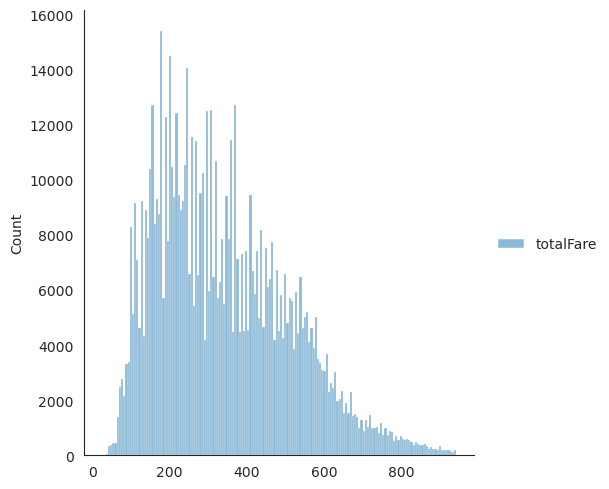

In [11]:
# Distribution plot using Seaborn
import seaborn as sns
import matplotlib.pyplot as plt
# Take the order total column and convert to a Pandas dataframe
df = sdf.select('totalFare').sample(False, 0.01).toPandas()
# Set the style for Seaborn plots
sns.set_style("white")
# Create the distribution plot
totalfare_distribution_plot = sns.displot(df)

In [ ]:
df['totalFare'].describe()

In [13]:
# Saving a Seaborn plot to GCS
import io
from google.cloud import storage
# Create a buffer to hold the figure
img_data = io.BytesIO()
# Write the figure to the buffer
totalfare_distribution_plot.savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data
img_data.seek(0)
# Connect to Google Cloud Storage
storage_client = storage.Client()
# Point to the bucket on Google Cloud Storage
bucket = storage_client.get_bucket('my-project-bucket-nrpc')

# Create a blob to hold the data. Give it a file name
blob = bucket.blob("totalfare_distribution_plot.png")
# Upload the img_data contents to the blob
blob.upload_from_file(img_data)

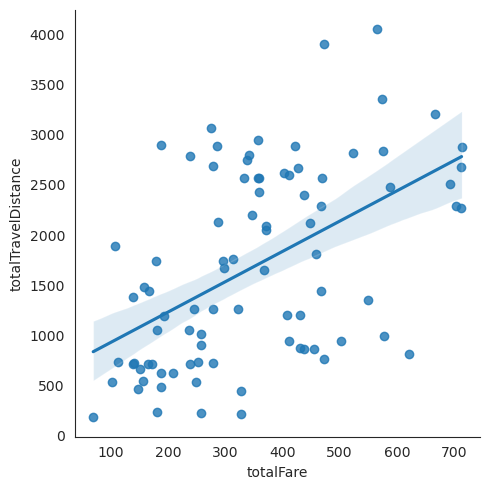

In [14]:
# Relationship plot using Seaborn
import seaborn as sns
# Take the order total column and convert to a Pandas dataframe
df = sdf.select('totalFare', 'totalTravelDistance').sample(False, 0.000001).toPandas()

# Set the style for Seaborn plots
sns.set_style("white")

# Create the relationship
totalfare_traveldur_relationship_plot = sns.lmplot(x='totalFare', y='totalTravelDistance', data=df)

In [15]:
# Saving Seaborn Relationship plot to GCS
import io
from google.cloud import storage
# Create a buffer to hold the figure
img_data = io.BytesIO()
# Write the figure to the buffer
totalfare_traveldur_relationship_plot.savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to Google Cloud Storage
storage_client = storage.Client()
# Point to the bucket
bucket = storage_client.get_bucket('my-project-bucket-nrpc')

# Create a blob to hold the data. Give it a file name
blob = bucket.blob("totalfare_traveldur_relationship_plot.png")
# Upload the img_data contents to the blob
blob.upload_from_file(img_data)